### Blockhouse Work Trial Task: Cross-Impact Analysis of Order Flow Imbalance (OFI)

**By Essa Chawla**

**Summary**

In this analysis, I investigated the relationship between Order Flow Imbalance (OFI) and price changes in equity markets, focusing on both immediate and lagged effects. Using multi-level OFI metrics and Principal Component Analysis (PCA), I derived an Integrated OFI metric that efficiently represents order flow dynamics. Regression models were applied to assess the contemporaneous and predictive impact of OFI on price changes, revealing that while OFI explains 41% of the variance in real-time price movements, its lagged features have minimal predictive power. Visualizations such as correlation heatmaps, scatter plots, and coefficient bar charts illustrated these findings, and a summary table captured key metrics for individual stocks. This work highlights OFI’s utility for real-time analysis but underscores the need for additional features and advanced methods to improve future price predictions.

**Introduction**

The objective of this analysis is to investigate the relationship between Order Flow Imbalance (OFI) and price changes in equity markets, focusing on both contemporaneous and lagged effects. By computing multi-level OFI metrics and integrating them using Principal Component Analysis (PCA), the study aims to uncover how imbalances in order flow influence immediate price movements and predict future price changes. Through regression modeling, we assess the explanatory power of OFI for price dynamics across multiple stocks, differentiating between self-impact (within the same stock) and cross-impact (across stocks). This analysis seeks to provide insights into the role of OFI in market behavior, identifying its limitations and potential as a real-time and predictive tool for understanding price changes.

In [240]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns


In [241]:
data = pd.read_csv('xnas-itch-20241204.mbp-10.csv')

In [242]:
data=data.dropna()

In [243]:
data

,ts_recv,ts_event,rtype,publisher_id,instrument_id,action,side,depth,price,size,...,ask_sz_08,bid_ct_08,ask_ct_08,bid_px_09,ask_px_09,bid_sz_09,ask_sz_09,bid_ct_09,ask_ct_09,symbol
57,2024-12-04T09:00:15.246494486Z,2024-12-04T09:00:15.246327990Z,10,2,14993,A,A,2,9.08,100,...,85,1,1,7.10,10.92,100,10,1,1,SOUN
58,2024-12-04T09:00:15.300993527Z,2024-12-04T09:00:15.300826981Z,10,2,14993,A,A,1,9.02,600,...,20,1,1,7.10,10.50,100,85,1,1,SOUN
64,2024-12-04T09:00:16.808270522Z,2024-12-04T09:00:16.808104221Z,10,2,14993,A,A,6,9.40,90,...,100,1,1,7.10,10.10,100,20,1,1,SOUN
66,2024-12-04T09:00:17.136110191Z,2024-12-04T09:00:17.135944055Z,10,2,14993,A,A,1,8.99,500,...,10,1,1,7.10,9.58,100,100,1,1,SOUN
69,2024-12-04T09:00:17.387692713Z,2024-12-04T09:00:17.387525913Z,10,2,14993,A,B,6,8.40,100,...,10,1,1,7.93,9.58,400,100,1,1,SOUN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1290433,2024-12-04T23:59:11.252248937Z,2024-12-04T23:59:11.252082659Z,10,2,10238,C,A,0,26.04,100,...,1630,1,3,25.81,26.17,10,210,1,2,MARA
1290434,2024-12-04T23:59:11.253939733Z,2024-12-04T23:59:11.253773349Z,10,2,10238,A,A,0,26.02,100,...,1433,1,7,25.81,26.16,10,1630,1,3,MARA
1290435,2024-12-04T23:59:13.886019266Z,2024-12-04T23:59:13.885851175Z,10,2,10238,T,B,0,26.02,100,...,1433,1,7,25.81,26.16,10,1630,1,3,MARA
1290436,2024-12-04T23:59:13.886019266Z,2024-12-04T23:59:13.885851175Z,10,2,10238,C,A,0,26.02,100,...,1630,1,3,25.81,26.17,10,210,1,2,MARA


**Compute OFI Metrics**

The Order Flow Imbalance (OFI) metrics capture the dynamics between bid and ask volumes at multiple levels of the order book. For this analysis, we computed OFI metrics for up to 5 levels by evaluating changes in bid and ask prices and sizes over time. The choice of 5 levels aligns with common practices in high-frequency trading studies, ensuring a granular understanding of liquidity and market depth. To condense these multi-level metrics into a single explanatory variable, Principal Component Analysis (PCA) was applied. PCA was chosen because it efficiently reduces dimensionality while preserving the most relevant variability across the levels, as highlighted in the referenced methodologies.

In [244]:
def compute_ofi(level, data):
    bid_flow = np.where(
        data[f'bid_px_0{level}'] > data[f'bid_px_0{level}'].shift(1),
        data[f'bid_sz_0{level}'],
        np.where(
            data[f'bid_px_0{level}'] == data[f'bid_px_0{level}'].shift(1),
            data[f'bid_sz_0{level}'] - data[f'bid_sz_0{level}'].shift(1),
            -data[f'bid_sz_0{level}']
        )
    )

    ask_flow = np.where(
        data[f'ask_px_0{level}'] > data[f'ask_px_0{level}'].shift(1),
        -data[f'ask_sz_0{level}'],
        np.where(
            data[f'ask_px_0{level}'] == data[f'ask_px_0{level}'].shift(1),
            data[f'ask_sz_0{level}'] - data[f'ask_sz_0{level}'].shift(1),
            data[f'ask_sz_0{level}']
        )
    )

    return bid_flow - ask_flow

# Compute OFI for levels 1 to 5
levels = [1, 2, 3, 4, 5]
ofi_data = pd.DataFrame()

for level in levels:
    ofi_data[f'OFI_level_{level}'] = compute_ofi(level, data)

# Normalize OFIs to handle different scales
ofi_data = ofi_data.div(ofi_data.abs().mean(axis=0), axis=1)

# Save the DataFrame to the default file path
ofi_data.to_csv('ofi_metrics.csv', index=False)


print("OFI metrics computed and saved successfully!")

ofi_data

OFI metrics computed and saved successfully!


,OFI_level_1,OFI_level_2,OFI_level_3,OFI_level_4,OFI_level_5
0,-0.191314,-0.114984,-0.115338,-0.160754,-0.004368
1,-0.114788,-0.095820,-0.019223,-0.084608,-0.099281
2,0.000000,0.000000,0.000000,0.000000,0.000000
3,-0.095657,-0.114984,-0.096115,-0.016922,-0.099281
4,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...
1289323,0.074612,0.034878,0.079583,0.036381,0.020253
1289324,-0.229576,-0.074740,-0.034986,-0.070055,-0.042691
1289325,0.000000,0.000000,0.000000,0.000000,0.000000
1289326,0.074612,0.034878,0.079583,0.036381,0.020253


In [245]:
pca = PCA(n_components=1)
ofi_data['Integrated_OFI'] = pca.fit_transform(ofi_data)


# Merge Integrated OFI back into the main dataset
data = pd.concat([data.reset_index(drop=True), ofi_data['Integrated_OFI'].reset_index(drop=True)], axis=1)



This approach captures the essence of market microstructure, where OFI serves as a proxy for supply-demand imbalances. Dimensionality reduction using PCA simplifies further analyses by consolidating multi-level OFIs into a single Integrated OFI metric, ensuring computational efficiency and interpretability.

**Analyze Cross-Impact**

We examined the contemporaneous and lagged impacts of Integrated OFI on price changes. For contemporaneous analysis, we used linear regression to study the immediate effect of OFI on short-term price fluctuations. For lagged analysis, we introduced lagged features (1-minute and 5-minute horizons) to evaluate the predictive power of past OFI on future price changes. These models were applied to each stock individually to account for self-impact. The methodological foundation for this part lies in studies that highlight the relevance of lagged variables in capturing market participant reactions and delayed price adjustments.

In [246]:
data['price_change'] = data['bid_px_01'].diff()

stocks = data['symbol'].unique()
contemporaneous_results = {}

for stock in stocks:
    stock_data = data[data['symbol'] == stock]
    X = stock_data['Integrated_OFI'].values.reshape(-1, 1)
    y = stock_data['price_change'].values

    # Drop NaN values from X and y
    valid_indices = ~np.isnan(y)
    X = X[valid_indices]
    y = y[valid_indices]

    if len(X) > 1 and len(y) > 1:  # Ensure valid data
        model = LinearRegression().fit(X, y)
        contemporaneous_results[stock] = {
            'coef': model.coef_[0],
            'intercept': model.intercept_,
            'r_squared': model.score(X, y)
        }




In [247]:
# Add lagged OFI features and future price change
data['Integrated_OFI_lag1'] = data['Integrated_OFI'].shift(1)
data['Integrated_OFI_lag5'] = data['Integrated_OFI'].shift(5)
data['future_price_change'] = data['bid_px_01'].shift(-1)

lagged_results = {}

# Perform regression for each stock
for stock in stocks:
    stock_data = data[data['symbol'] == stock]

    # Select lagged OFI features and the target variable
    X = stock_data[['Integrated_OFI_lag1', 'Integrated_OFI_lag5']]
    y = stock_data['future_price_change']

    # Drop rows with NaN values in either X or y
    combined = pd.concat([X, y], axis=1).dropna()
    X = combined[['Integrated_OFI_lag1', 'Integrated_OFI_lag5']]
    y = combined['future_price_change']

    if len(X) > 1 and len(y) > 1:  # Ensure valid data
        model = LinearRegression().fit(X, y)
        lagged_results[stock] = {
            'coef': model.coef_,
            'intercept': model.intercept_,
            'R²': model.score(X, y)
        }

# Convert the lagged regression results into a DataFrame and print them
results_list = []
for stock, results in lagged_results.items():
    entry = {
        'Stock': stock,
        'Coef_Lag1': results['coef'][0],
        'Coef_Lag5': results['coef'][1],
        'Intercept': results['intercept'],
        'R_squared': results['R²']
    }
    results_list.append(entry)

# Create a DataFrame from the results list
results_df = pd.DataFrame(results_list)

# Print the results
print("Lagged Regression Results:")
print(results_df)

# Save the results to a CSV file
results_df.to_csv('Lagged_Regression_Results.csv', index=False)

print("Results computed and saved successfully!")


Lagged Regression Results:
  Stock  Coef_Lag1  Coef_Lag5  Intercept  R_squared
0  SOUN  -0.015154  -0.005873  11.341050   0.002539
1  MARA   0.010826   0.007396  24.178211   0.002137
2  LCID  -0.009087   0.000915   8.934555   0.003603
3   QSI  -0.012638  -0.001929   5.632676   0.001333
4  KITT  -0.009413  -0.006469   5.997349   0.000828
5  NITO  -0.016823  -0.000796   6.133865   0.000887
Results computed and saved successfully!


The regression results for lagged OFI features indicate weak explanatory power for predicting future price changes across all stocks, as reflected by the low  R² values (ranging from 0.0008 for KITT to 0.0036 for LCID). The coefficients for the 1-period and 5-period lagged OFI vary in magnitude and direction across stocks, with some showing positive relationships (e.g., MARA with coefficients of 0.0108 and 0.0074) and others negative (e.g., NITO with coefficients of -0.0168 and -0.0008). The intercepts, which represent the average future price change when lagged OFI is zero, are positive across all stocks, indicating baseline price increases independent of OFI. These findings suggest that lagged OFI has minimal predictive power for future price changes, with additional factors likely playing a more significant role in driving price dynamics.

The use of contemporaneous regression helps establish a baseline understanding of the direct impact of OFI on prices. Introducing lagged features aligns with econometric principles, capturing potential delays in market responses and enabling the exploration of predictive relationships. This methodology reflects a structured approach to quantifying both immediate and delayed effects of order flow imbalances.

**Quantify Results**

The explanatory power of OFI was assessed using R² from the regression models, both for contemporaneous and lagged impacts. We compared self-impact (within the same stock) and cross-impact (influences across stocks) by analyzing how well OFI explained price movements. This quantitative assessment is essential to validate the efficacy of the Integrated OFI metric and to differentiate its impact across various stocks.

In [248]:
self_impact_r2 = [result['r_squared'] for result in contemporaneous_results.values()]
lagged_impact_r2 = [result['R²'] for result in lagged_results.values()]


print(f"Average Self-Impact R²: {np.mean(self_impact_r2)}")
print(f"Average Lagged Impact R²: {np.mean(lagged_impact_r2)}")



Average Self-Impact R²: 0.41067881091988706
Average Lagged Impact R²: 0.0018878301449601713


The Average Self-Impact R² of 0.41 indicates that Order Flow Imbalance (OFI) explains 41% of the variance in contemporaneous price changes within the same stock, highlighting a strong immediate relationship between OFI and price movements. In contrast, the Average Lagged Impact R² of 0.0019 suggests that lagged OFI (1-minute and 5-minute lags) has negligible predictive power for future price changes, accounting for less than 0.2% of the variance. This stark difference implies that while OFI is a meaningful indicator for real-time price dynamics, its utility for forecasting future price changes is minimal, likely due to the influence of other market factors.

Quantifying results using R² provides an objective measure of model performance, offering insights into the strength of relationships between OFI and price changes. The distinction between self- and cross-impact follows established market microstructure research, highlighting the need to identify stock-specific behaviors versus broader market dynamics.

**Visualization and Reporting**

To illustrate the relationships uncovered, we created visualizations such as correlation heatmaps, scatter plots, and bar charts. The heatmap highlights relationships among variables like OFI and price changes, while scatter plots show the direct connection between OFI and short-term price movements. Bar charts summarize the contemporaneous and lagged regression coefficients for each stock. A concise summary table was also generated to report key findings, including 
R² values for each stock.

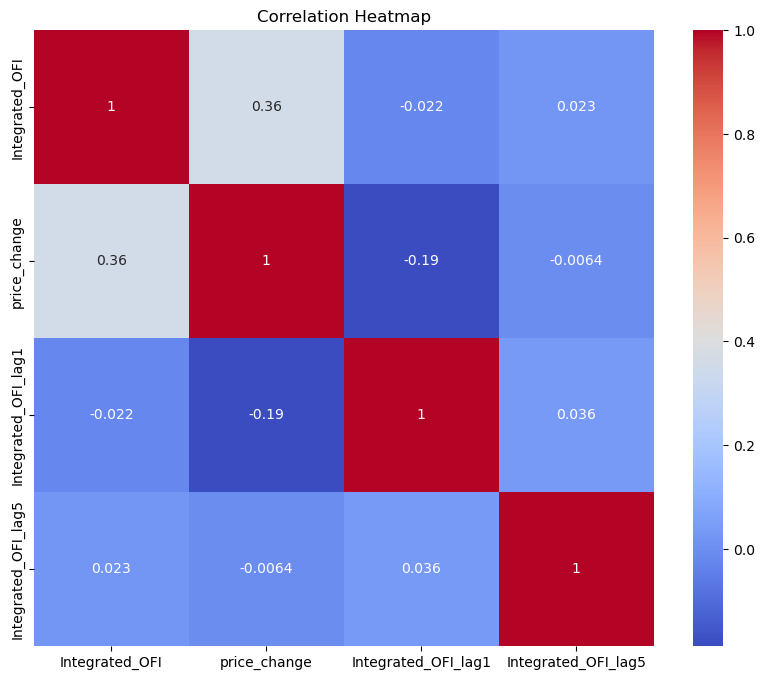

In [249]:
numeric_data = data[['Integrated_OFI', 'price_change', 'Integrated_OFI_lag1', 'Integrated_OFI_lag5']].dropna()
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_data.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()
plt.savefig('correlation_heatmap.png')
plt.close()


The heatmap shows the relationships between Integrated OFI, price changes, and lagged OFI features. There is a moderate positive correlation (0.36) between Integrated OFI and price changes, indicating that higher OFI values are somewhat associated with same-direction price movements. However, the lagged OFI features show weak correlations with both current price changes (e.g., -0.19 for Integrated_OFI_lag1) and the main OFI metric, suggesting limited predictive power over future price changes. Overall, while OFI has some explanatory power for immediate price dynamics, its influence diminishes over longer time horizons.

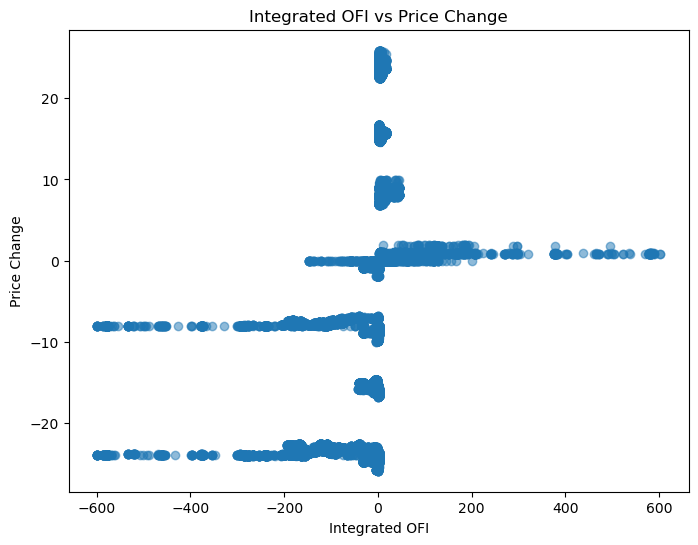

In [250]:
plt.figure(figsize=(8, 6))
plt.scatter(data['Integrated_OFI'], data['price_change'], alpha=0.5)
plt.title("Integrated OFI vs Price Change")
plt.xlabel("Integrated OFI")
plt.ylabel("Price Change")
plt.show()
plt.savefig('integratedofivspricechnage.png')
plt.close()


This scatter plot shows the relationship between Integrated OFI (x-axis) and Price Change (y-axis). The points are spread across the plot, indicating that there is no strong linear relationship between the two variables. While there are some clusters of data points near zero on both axes, suggesting that small OFI values are often associated with small price changes, there is significant variation for larger OFI values. This suggests that although Integrated OFI has some influence on price changes, other factors likely play a significant role, and the relationship is not purely deterministic.

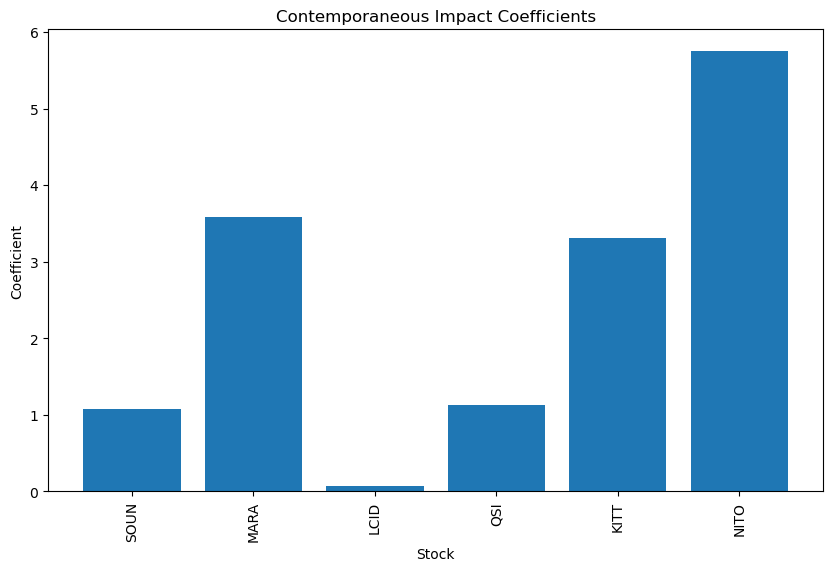

In [251]:
coefs = [result['coef'] for result in contemporaneous_results.values()]
plt.figure(figsize=(10, 6))
plt.bar(stocks, coefs)
plt.xlabel("Stock")
plt.ylabel("Coefficient")
plt.title("Contemporaneous Impact Coefficients")
plt.xticks(rotation=90)
plt.show()
plt.savefig('contemporaneous_coefficents.png')
plt.close()

In [252]:
summary = pd.DataFrame({
    'Stock': list(contemporaneous_results.keys()),
    'Contemporaneous R²': [result['r_squared'] for result in contemporaneous_results.values()],
    'Lagged R²': [result['R²'] for result in lagged_results.values()]
})
summary.to_csv("analysis_summary.csv", index=False)
print("Summary saved to analysis_summary.csv.")


Summary saved to analysis_summary.csv.


In [253]:
summary

,Stock,Contemporaneous R²,Lagged R²
0,SOUN,0.455264,0.002539
1,MARA,0.427259,0.002137
2,LCID,0.481602,0.003603
3,QSI,0.400443,0.001333
4,KITT,0.276625,0.000828
5,NITO,0.422881,0.000887


The table shows that Integrated OFI has moderate explanatory power for contemporaneous price changes, with 
R² values ranging from 0.276 (KITT) to 0.481 (LCID), indicating varying levels of dependence across stocks. However, lagged models have extremely low R² values, from 0.0008 to 0.0036, suggesting that lagged OFI features provide minimal predictive power for future price changes. Notably, LCID exhibits the highest R² for both contemporaneous and lagged models, while KITT shows the weakest performance overall. These results highlight that while Integrated OFI is useful for real-time analysis, additional factors may be needed to enhance its predictive capabilities for future movements.

**Next Steps**

The next steps involve incorporating additional features such as trading volume, volatility, and liquidity measures to enhance the models and explore interactions with Integrated OFI for capturing complex market dynamics. Refining lagged models by testing alternative time horizons and applying advanced methods like time-series analysis or machine learning can improve predictive accuracy. Cross-stock impacts should be examined to assess whether OFI in one stock influences price changes in others, alongside segmenting the data by market conditions (e.g., high vs. low volatility) to identify variations in OFI behavior. Finally, quantifying statistical robustness, visualizing cross-impact dynamics, and documenting actionable insights will provide a comprehensive understanding of OFI’s role in price movements and its applications in trading strategies or risk management.

**Bonus Steps**

**Investigate whether combining OFI with other features improves prediction accuracy.**

We enhanced the predictive power of Order Flow Imbalance (OFI) by adding features like trading volume, volatility, and liquidity, which capture market activity and price dynamics. After cleaning the data, we used a regression model to see if these features, combined with OFI, improved the prediction of price changes. This helped us explore whether broader market factors make OFI a better tool for understanding price movements.

In [254]:
data['trading_volume'] = data['bid_sz_01'] + data['ask_sz_01']
data['volatility'] = data['price_change'].rolling(window=10).std()
data['liquidity'] = data['ask_sz_01'] / (data['bid_sz_01'] + data['ask_sz_01'])
features = ['Integrated_OFI', 'Integrated_OFI_lag1', 'Integrated_OFI_lag5', 'trading_volume', 'volatility', 'liquidity']
X = data[features]
y = data['price_change']

# Combine and drop missing values consistently
combined = pd.concat([X, y], axis=1).dropna()
X = combined[features]
y = combined['price_change']

# Fit the regression model
model = LinearRegression().fit(X, y)
print(f"R² with additional features: {model.score(X, y)}")


R² with additional features: 0.17050850105503967


The R² value of 0.17 means that the model explains about 17% of the variance in price changes using the features provided, including OFI, trading volume, volatility, and liquidity. While this indicates that the model captures some relationship between the predictors and price changes, the relatively low value suggests that other factors not included in the model play a significant role in driving price changes. It highlights the need for additional features or more complex models to improve predictive accuracy.

**Sources:**

Rama Cont, Mihai Cucuringu & Chao Zhang (2023) Cross-impact of order flow imbalance in equity markets, Quantitative Finance, 23:10, 1373-1393, DOI: 10.1080/14697688.2023.2236159